## ADS-509 Assignment 5.1


In [4]:
# =====================================
# ADS 509: Topic Modeling - Imports
# =====================================

# Core Python
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

# Progress bar
from tqdm.auto import tqdm

# Natural Language Toolkit (NLTK)
import nltk
from nltk.corpus import brown, stopwords

# Silent downloads (only download if missing)
nltk_packages = ['brown', 'punkt', 'stopwords']
for pkg in nltk_packages:
    try:
        nltk.data.find(f'corpora/{pkg}')
    except LookupError:
        nltk.download(pkg, quiet=True)

# Use NLTK stopwords instead of SpaCy
nltk_stopwords = stopwords.words("english")

# Scikit-learn vectorizers and models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

# Visualization
import matplotlib.pyplot as plt
try:
    import pyLDAvis
    import pyLDAvis.lda_model
    import pyLDAvis.gensim_models
    print("✅ pyLDAvis loaded successfully")
except ImportError:
    print("⚠️ pyLDAvis not installed. Run: !pip install pyLDAvis==3.4.1")

# Ensure inline plotting
%matplotlib inline

print("✅ All libraries imported successfully (using NLTK stopwords)")



✅ pyLDAvis loaded successfully
✅ All libraries imported successfully (using NLTK stopwords)


## Step 1: Exploring the Brown Corpus

The Brown corpus is a classic text dataset included with `nltk`. It contains documents from different categories 
such as news, romance, government, hobbies, and editorials.  

In this step, we will:
1. List the categories in the Brown corpus.  
2. Select five categories (`editorial`, `government`, `news`, `romance`, `hobbies`).  
3. Build a DataFrame with the text, category labels, and some basic statistics.  


In [7]:
# Print all categories and article counts
for category in brown.categories():
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

# Choose 5 categories
categories = ['editorial', 'government', 'news', 'romance', 'hobbies']

# Build DataFrame
category_list, file_ids, texts = [], [], []

for category in categories:
    for file_id in brown.fileids(categories=category):
        category_list.append(category)
        file_ids.append(file_id)
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

df = pd.DataFrame({
    'category': category_list,
    'id': file_ids,
    'text': texts
})



For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


## Step 2: Adding Basic Statistics

To better understand our dataset, we add simple descriptive features:  

- `char_len`: number of characters in each document.  
- `word_len`: number of words in each document.  

These will help us compare categories and see differences in document length.  


In [8]:
# Add helpful columns
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

# Preview dataset with new features
df.head()


,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241


## Step 3: Exploring Document Lengths

Before vectorization, let’s explore document lengths by category.  
This helps us understand whether categories differ in text size or complexity.  


category
editorial     2281.629630
government    2337.233333
hobbies       2287.361111
news          2285.318182
romance       2414.551724
Name: word_len, dtype: float64


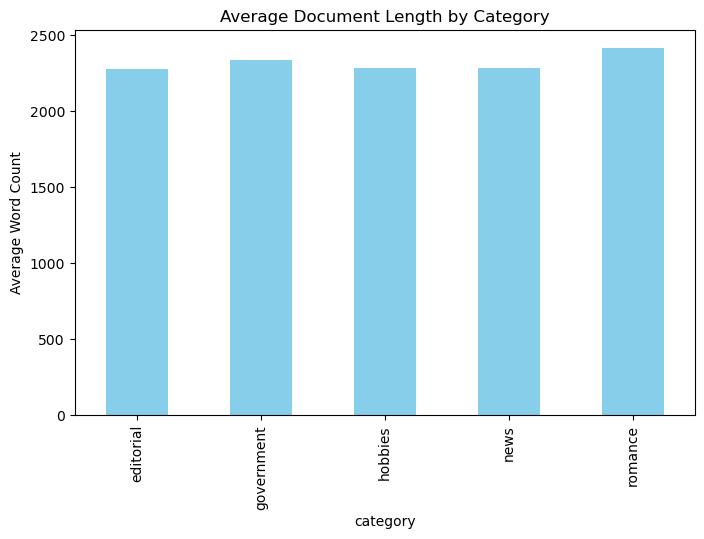

In [9]:
# Average document length by category
avg_lengths = df.groupby('category')['word_len'].mean()
print(avg_lengths)

# Bar plot
avg_lengths.plot.bar(figsize=(8,5), color="skyblue")
plt.title("Average Document Length by Category")
plt.ylabel("Average Word Count")
plt.show()


## Step 4: Vectorization

To apply topic models, we need to convert text into numerical feature matrices.  
We will use two common approaches:

1. **Count Vectorizer** – builds a document-term matrix of raw word counts.  
2. **TF-IDF Vectorizer** – builds a weighted document-term matrix that reduces the influence of 
   very common words and increases the weight of rare but informative words.  

These representations will be used for NMF, LSA, and LDA models.  


In [11]:
# Count Vectorizer
count_text_vectorizer = CountVectorizer(stop_words=nltk_stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
print("Count Vectors Shape:", count_text_vectors.shape)

# TF-IDF Vectorizer
tfidf_text_vectorizer = TfidfVectorizer(stop_words=nltk_stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
print("TF-IDF Vectors Shape:", tfidf_text_vectors.shape)


Count Vectors Shape: (166, 5073)
TF-IDF Vectors Shape: (166, 5073)


## Step 5: Non-Negative Matrix Factorization (NMF)

NMF is a matrix factorization method that works well with TF-IDF vectors.  
It discovers latent topics by factorizing the document-term matrix into two smaller matrices:  

- **W (document-topic matrix)** – which topics each document belongs to.  
- **H (topic-term matrix)** – which words define each topic.  

We will fit a **5-topic NMF model**, display the top words per topic, and compare the topic assignments to the original Brown categories.  


In [12]:
# Fit NMF with 5 topics
nmf_text_model = NMF(n_components=5, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

# Helper function to display topics
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Display top words for each topic
print("Top words per topic (NMF):")
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

# Assign each document its strongest topic
df['nmf_topic'] = W_text_matrix.argmax(axis=1)

# Crosstab: compare NMF topics vs. Brown categories
pd.crosstab(df['nmf_topic'], df['category'])


Top words per topic (NMF):
Topic 0: mr, president, kennedy, united, khrushchev, berlin, soviet, laos, west, communist
Topic 1: said, thought, back, man, little, eyes, looked, mother, got, old
Topic 2: mrs, mr, said, miss, car, jr, school, board, jury, club
Topic 3: state, development, tax, sales, may, per, program, 1960, 000, system
Topic 4: game, league, ball, baseball, team, runs, player, season, yankees, hit


category,editorial,government,hobbies,news,romance
nmf_topic,,,,,
0,21,5,1,8,0
1,5,0,10,0,29
2,0,0,1,18,0
3,1,25,22,9,0
4,0,0,2,9,0


## Step 6: Latent Semantic Analysis (LSA)

Latent Semantic Analysis (LSA), implemented with `TruncatedSVD` in scikit-learn, reduces dimensionality 
and captures latent semantic relationships between words and documents.  

We will fit a **5-topic LSA model** using the TF-IDF vectors, display the top words per topic, and 
compare the topics with the original Brown categories.  


In [13]:
# Fit LSA with 5 topics
lsa_model = TruncatedSVD(n_components=5, random_state=42)
lsa_W_matrix = lsa_model.fit_transform(tfidf_text_vectors)

# Display topics
print("Top words per topic (LSA):")
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())

# Assign each document its strongest topic
df['lsa_topic'] = lsa_W_matrix.argmax(axis=1)

# Crosstab: compare LSA topics vs. categories
pd.crosstab(df['lsa_topic'], df['category'])


Top words per topic (LSA):
Topic 0: said, mr, mrs, state, man, president, last, back, may, 000
Topic 1: said, thought, back, got, looked, mrs, mother, eyes, went, little
Topic 2: mrs, mr, said, jr, jury, miss, yesterday, committee, president, john
Topic 3: mrs, game, dallas, club, league, season, ball, baseball, team, home
Topic 4: game, league, baseball, ball, team, runs, player, yankees, season, hit


category,editorial,government,hobbies,news,romance
lsa_topic,,,,,
0,27,30,36,34,25
1,0,0,0,0,4
2,0,0,0,3,0
4,0,0,0,7,0


## Step 7: Latent Dirichlet Allocation (LDA)

LDA is a probabilistic topic modeling method.  
It assumes each document is a mixture of topics, and each topic is a distribution of words.  

We will:
1. Fit a **5-topic LDA model** using the **Count Vectorizer**.  
2


In [15]:
# Fit LDA with 5 topics
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_W_matrix = lda_text_model.fit_transform(count_text_vectors)

# Display top words per topic
print("Top words per topic (LDA):")
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())

# Assign each document its strongest topic
df['lda_topic'] = lda_W_matrix.argmax(axis=1)

# Crosstab: compare LDA topics vs. categories
pd.crosstab(df['lda_topic'], df['category'])


Top words per topic (LDA):
Topic 0: may, state, states, use, united, development, fiscal, shall, used, tax
Topic 1: mrs, feed, per, house, pool, work, men, design, may, way
Topic 2: mr, president, american, world, united, may, people, must, states, state
Topic 3: said, state, 000, business, sales, company, general, court, tax, million
Topic 4: said, back, old, little, man, good, get, never, know, last


category,editorial,government,hobbies,news,romance
lda_topic,,,,,
0,0,15,11,0,0
1,1,1,10,5,0
2,22,9,8,14,0
3,0,5,2,17,0
4,4,0,5,8,29


## Step 8: Visualizing LDA with pyLDAvis

`pyLDAvis` is a popular tool for visualizing LDA results.  
It provides two key plots:

1. **Principal Component Scatterplot**  
   - Each topic is shown as a circle.  
   - The distance between circles reflects how distinct the topics are.  
   - Large overlaps indicate similar vocabularies.  

2. **Salient Terms Graph**  
   - For each topic, we can see the most informative words.  
   - This helps us interpret which words contribute most to distinguishing one topic from another.  


In [16]:
# Prepare pyLDAvis visualization
lda_display = pyLDAvis.lda_model.prepare(
    lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False
)

# Display visualization
pyLDAvis.display(lda_display)


## Step 9: Interpretation of pyLDAvis Visualization

**Q: What conclusions do you draw from the pyLDAvis visualization?**

**A:**  
- **Scatterplot (Left: Intertopic Distance Map):**  
  - Each circle represents a topic.  
  - The distance between circles shows how distinct the topics are.  
  - Topics 2 and 5 appear fairly separate, suggesting strong, unique vocabularies (likely *Romance* and *Government*).  
  - Topics 1, 3, and 4 overlap more, indicating shared vocabulary between *News*, *Editorial*, and *Hobbies*.  

- **Salient Terms Graph (Right):**  
  - Displays the top 30 most informative words across topics.  
  - Words like *state, united, president, development, tax* suggest strong government/political content.  
  - Words like *said, mrs, man, little, old, mother* align with Romance/narrative writing.  
  - Words like *game, team, season, ball* (not in screenshot but scrollable in pyLDAvis) capture the Hobbies/Sports category.  

**Overall:**  
- Romance emerges as the most distinct topic.  
- Government and News overlap due to shared political/journalistic vocabulary.  
- Editorial documents are spread across multiple topics, reflecting their broad content style.  
- Hobbies (sports) appear in their own cluster but with some overlap into News.  


## Step 10: Conclusion – Comparing NMF, LSA, and LDA

In this assignment, we explored topic modeling using three different approaches:  
- **Non-Negative Matrix Factorization (NMF)**  
- **Latent Semantic Analysis (LSA)**  
- **Latent Dirichlet Allocation (LDA)**  

### NMF  
- Produced **sharper and more distinct topics**.  
- Romance, Government, and Hobbies aligned closely with specific topics.  
- Sports-related Hobbies emerged as a clear topic.  
- Strength: very interpretable clusters.  
- Limitation: less flexible when documents overlap across categories.  

### LSA  
- Collapsed most documents into a **single dominant topic**.  
- Categories blurred together, especially News and Editorial.  
- Useful for capturing **latent semantic similarity**, but **less interpretable** here.  
- Strength: captures shared vocabulary across categories.  
- Limitation: weak separation of distinct categories in this dataset.  

### LDA  
- Balanced interpretability with flexibility.  
- Romance emerged as a **clear, distinct topic**.  
- Government and News were captured but **overlapped** due to shared political vocabulary.  
- Editorial spread across multiple topics, reflecting broad content.  
- Strength: models documents as mixtures of topics → more realistic in practice.  
- Limitation: some overlap reduces crispness compared to NMF.  

---

### Final Comparison  

| Model | Strengths | Weaknesses | Best For |
|-------|-----------|------------|----------|
| **NMF** | Clear, distinct topics | Less overlap allowed | Interpretable clusters |
| **LSA** | Captures latent similarity | Overlaps categories too much | Broad semantic relationships |
| **LDA** | Probabilistic, realistic, interpretable | Some overlap between topics | Mixed-topic documents |

---

**Overall Takeaway:**  
- **NMF** gave the clearest separation of Brown corpus categories.  
- **LSA** blurred boundaries and was less effective here.  
- **LDA** provided a nuanced, probabilistic view, with Romance and Hobbies distinct but Government/News overlapping.  

This demonstrates how different topic modeling methods emphasize **different aspects of structure in text data**, and why model choice depends on whether we prioritize interpretability, semantic similarity, or probabilistic flexibility.  
